# Representation Part: Superclass identification and Intelligent Reasoning

## Superclass identification

### Step 1: Dataset loading and first classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from src.utils.utils import *
from src.utils.data_loading_functions import *
from src.utils.metadata_functions import *
from src.utils.statistics import *
from src.utils.superclasses_functions import *

from sklearn import datasets, svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import scipy

Dataset

In [2]:
# Load data
label_path="data/MLinApp_course_data/tcga_mir_label.csv"
data_path="data/MLinApp_course_data/tcga_mir_rpm.csv"
miRNA_data, miRNA_labels, miRNA_tissues = load_data(data_path, label_path)

In [3]:
# Adjust data
miRNA_data, miRNA_labels, miRNA_tissues, labels, dictionary, lab = class_balancing(miRNA_data, miRNA_labels, miRNA_tissues)

Adjusting dataset...
Removed classes: 'COAD' 'LAML' 'OV' 'GBM'!


Balancing BRCA data...
BRCA data balanced!


Processing labels...
Done!
['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'DLBC' 'ESCA' 'HNSC' 'KICH' 'KIRC'
 'KIRP' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'PAAD' 'PCPG' 'PRAD' 'READ'
 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC' 'UCS' 'UVM']
['Adrenal gland' 'Base of tongue' 'Bladder'
 'Bones, joints and articular cartilage of limbs'
 'Bones, joints and articular cartilage of other and unspecified sites'
 'Brain' 'Breast' 'Bronchus and lung' 'Cervix uteri' 'Colon'
 'Connective, subcutaneous and other soft tissues' 'Corpus uteri'
 'Esophagus' 'Eye and adnexa' 'Floor of mouth' 'Gallbladder' 'Gum'
 'Heart, mediastinum, and pleura' 'Hypopharynx' 'Kidney' 'Larynx' 'Lip'
 'Liver and intrahepatic bile ducts' 'Lymph nodes' 'Meninges' 'Oropharynx'
 'Other and ill-defined sites'
 'Other and ill-defined sites in lip, oral cavity and pharynx'
 'Other and unspecified major salivary glands'
 'Other and

In [4]:
#Z-Score normalization
miRNA_data = normalize_data(miRNA_data)

Normalizing data...


Data normalized


In [5]:
# Splitting the data
train_data, val_data, train_label, val_label = split_data(miRNA_data,miRNA_labels)

Splitting data...
There are 29  classes
Training set dimensions: (7460, 1881)
Validation set dimensions: (1865, 1881)


Dimensions of a single sample: (1881,)


Tuning SVM for first classification

In [8]:
from sklearn.model_selection import RandomizedSearchCV

#SVM prior-classification and superclass identification confusion matrix based.
#classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)

random_grid_svm = {'kernel': ['rbf', 'poly', 'sigmoid'],
                   'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
                   'degree': [2,3,4,5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]}

In [9]:
#Searching for best parameters and estimator
search = RandomizedSearchCV(estimator=svm.SVC(),
                            param_distributions= random_grid_svm,
                            scoring='balanced_accuracy',
                            n_iter=10,
                            cv=5,
                            verbose=1,
                            random_state=42,
                            n_jobs=-1)

In [ ]:
search.fit(train_data, train_label)
classifier = search.best_estimator_

In [6]:
#Running SVC 
model = svm.SVC(C=20, kernel='rbf', gamma=0.001, degree=4, class_weight= 'balanced')

K Fold

In [7]:
# Re-Training of the optimal model through cross validation, this is made to take the predictions.
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
actual_classes, predicted_classes, _ , classifier = cross_val_predict(model, kfold, train_data, np.array(lab2int(labels=train_label, dictionary=dictionary)))

### Step 2: Confusion matrix plot and superclass identification

Confusion matrix

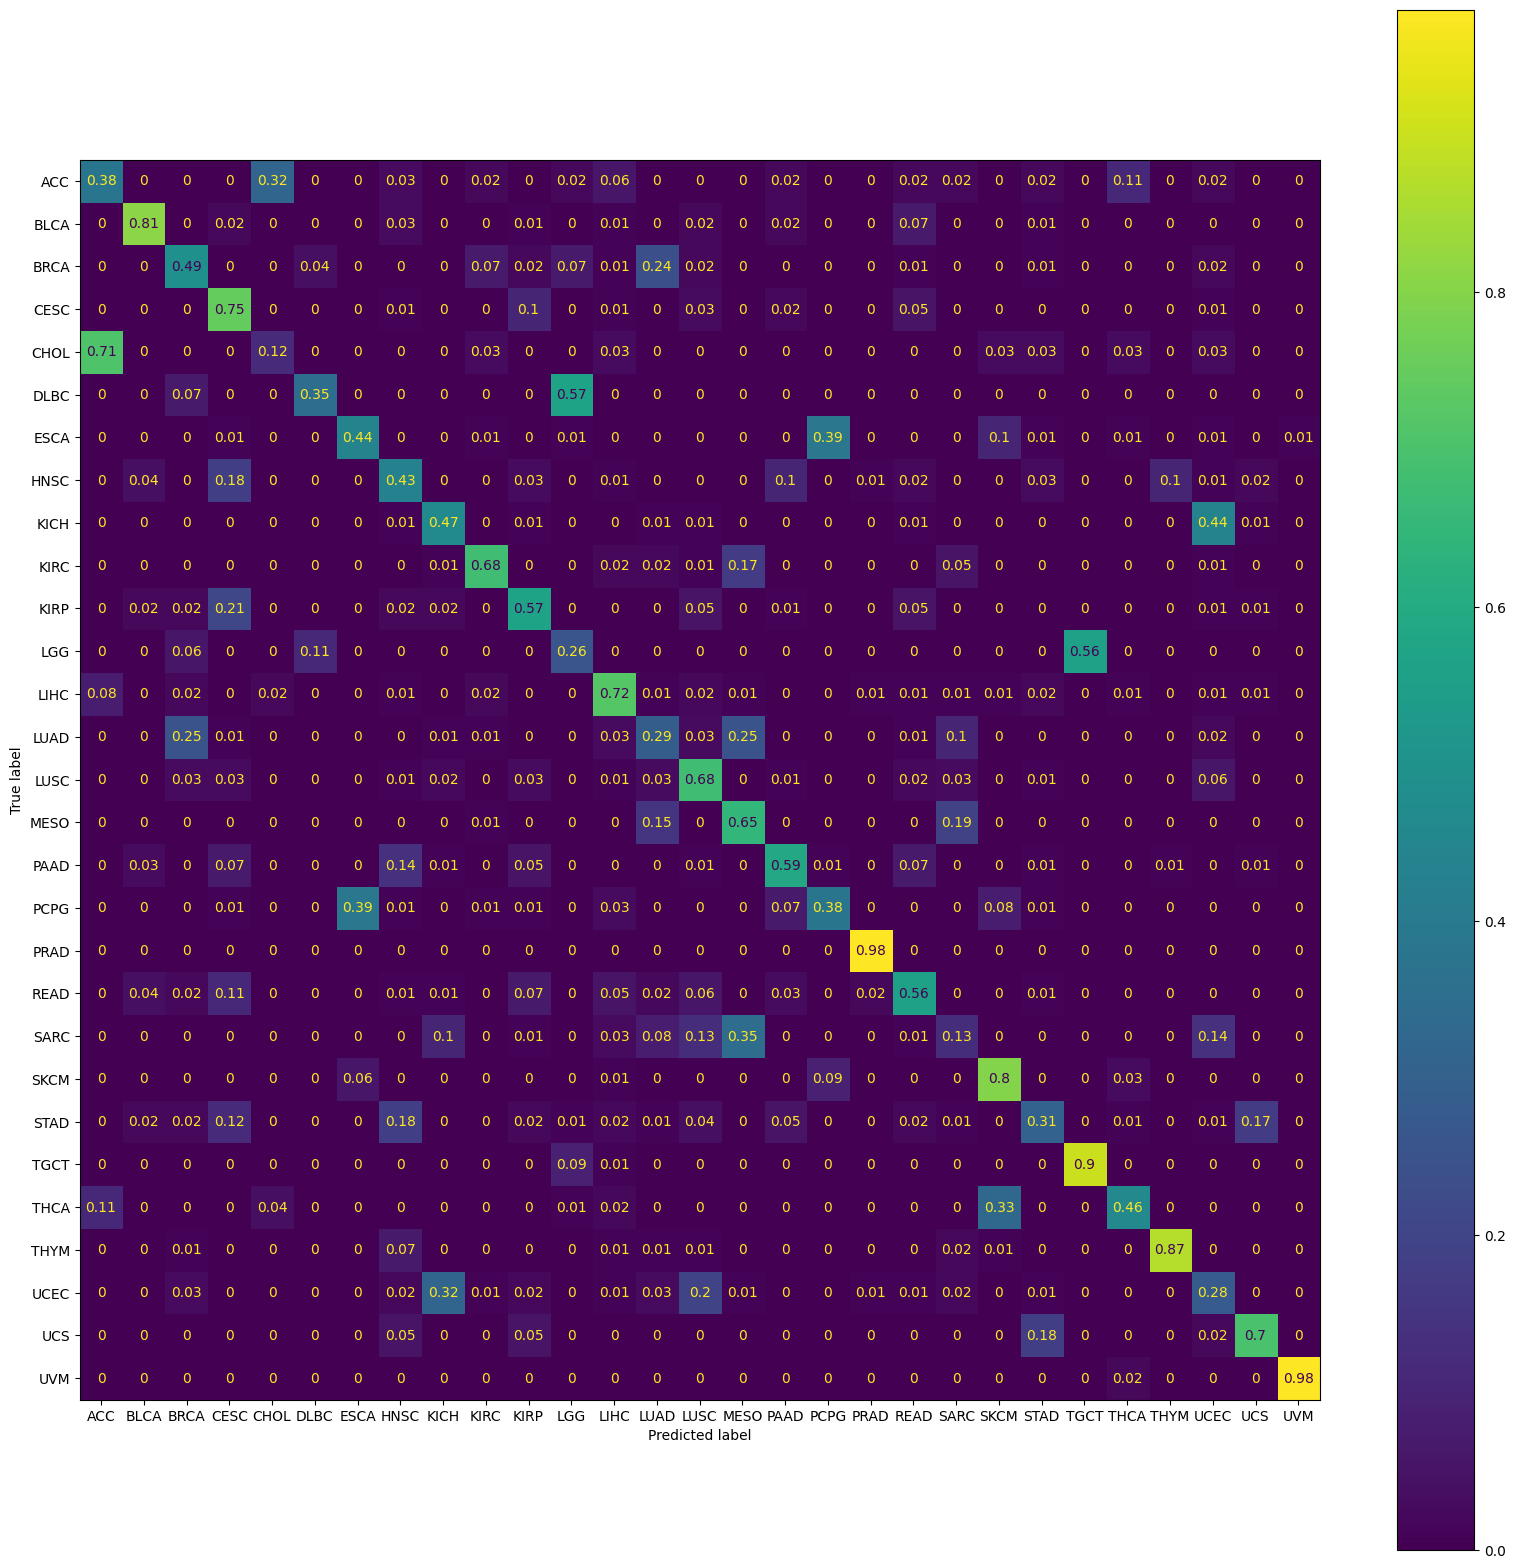

In [9]:
#Plotting confusion matrix. For the selection of superclass, use "cm".

cm=show_matrix(actual_classes, predicted_classes, labels[0])

#Convert the confusion matrix into a metric matrix (superclass identification)
#Taking the number of the unique labels 
n_classes = np.unique(train_label).size
metric_matrix=confusion_matrix_to_distance_matrix(cm,n_classes)

Dendogram

d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\src\utils\superclasses_functions.py:34: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = shc.linkage(metric_matrix,


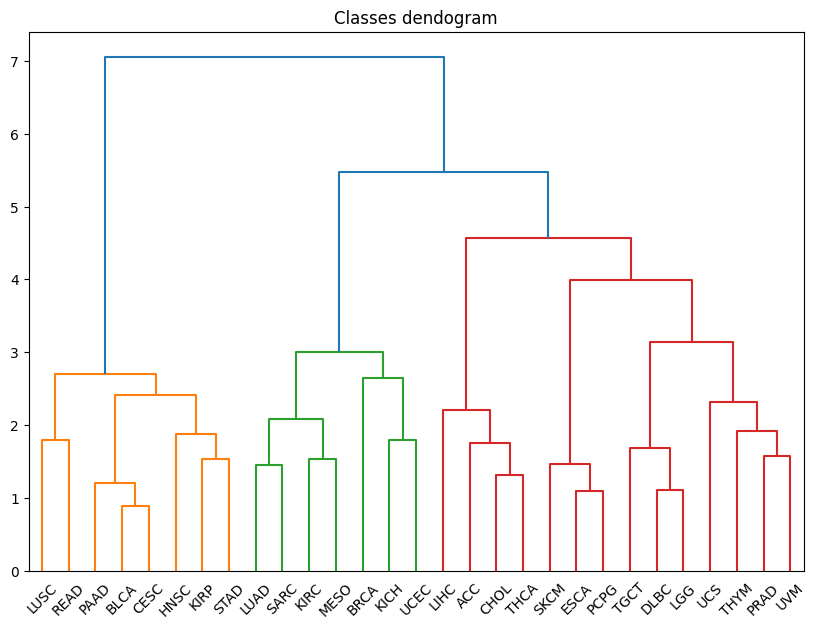

In [12]:
#We know that i is the class to predict and j is the predicted class. So cm[i][j] is the miss-classification ratio 
#Plotting the dendogram
n_classes = np.unique(train_label).size
plot_dendogram(metric_matrix, labels)

Hierarchical clustering for superclass identification

In [14]:
#We will grup classes in 5 superclasses minimizing the inter-class overlap
#Then obtain cluster per label. The order is the same of the labels
cluster_per_label=superclass_identification(metric_matrix)
superclasses=divide_in_superclass(cluster_per_label,labels)

7
['DLBC', 'LGG', 'PRAD', 'TGCT', 'THYM', 'UCS', 'UVM']
8
['BLCA', 'CESC', 'HNSC', 'KIRP', 'LUSC', 'PAAD', 'READ', 'STAD']
7
['BRCA', 'KICH', 'KIRC', 'LUAD', 'MESO', 'SARC', 'UCEC']
4
['ACC', 'CHOL', 'LIHC', 'THCA']
3
['ESCA', 'PCPG', 'SKCM']
Adjusting classes...
New superclasses
6
['DLBC', 'LGG', 'PRAD', 'TGCT', 'THYM', 'UCS']
8
['BLCA', 'CESC', 'HNSC', 'KIRP', 'LUSC', 'PAAD', 'READ', 'STAD']
7
['BRCA', 'KICH', 'KIRC', 'LUAD', 'MESO', 'SARC', 'UCEC']
3
['ACC', 'CHOL', 'LIHC']
5
['ESCA', 'PCPG', 'SKCM', 'THCA', 'UVM']


d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\scipy\cluster\hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## Metadata creation and classification

### Step 1: Create metadata

Metadata creation

In [15]:
# We define ovo and ovr models to create the features of the metadata:
# The feature of the metadata consists of the predictions of the model for each superclass.
# Since we use n = 5 superclasses, we will have n(n-1)/2 = 10 features for the ovo model and n features for the ovr model.
# Each features is 0 or 1, depending on the prediction of the model for each superclass.

ovo_model = ovo(svm.SVC(C=20, class_weight='balanced', gamma=0.001), n_jobs=-1) #One vs One with GradientBoostingClassifier
ovr_model = ovr(svm.SVC(C=20, class_weight='balanced', gamma=0.001), n_jobs=-1) #One vs Rest with GradientBoostingClassifier



In [19]:
# We create the metadata for the training data using cross-validation
# First we convert the labels into metalabels

metalabels = lab2super(train_label, superclasses)

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
metadata, metalabels, ordered_train  = meta_data_creation_train(ovo_model, ovr_model, kfold, train_data, np.array(metalabels))


Starting k-fold cross validation...

Fold 1
ovo done
ovr done
Metadata for 1° split created
Fold 2
ovo done
ovr done
Metadata for 2° split created
Fold 3
ovo done
ovr done
Metadata for 3° split created
Fold 4
ovo done
ovr done
Metadata for 4° split created
Fold 5
ovo done
ovr done
Metadata for 5° split created
Metadata for the whole dataset created!


In [20]:
# Now we train the ovo and ovr on the whole dataset
ovo_trained , ovr_trained = train_ovo_ovr(ovo_model, ovr_model, train_data, metalabels)

Starting training set metadata creation...

ovo done
ovr done


In [24]:
#Save models
models_path = "src/models/metadata_models/"
save_model(ovo_trained, models_path, "ovo_trained_1")
save_model(ovr_trained, models_path, "ovr_trained_1")

#Save the metadata
save_metadata(metadata, "train", metalabels, ordered_train, "_1")

Saving metadata...
Complete!


### Step 2: Metadata classification

In [25]:
# We define the random forest model for metadata classification
# We use 10 fold cross validation to get the predictions of the model for each sample of the training data

rf_model = RandomForestClassifier(max_depth=None, n_estimators=200, class_weight="balanced_subsample", n_jobs=-1, criterion="gini")

kfold = KFold(n_splits=10, random_state=42, shuffle=True)
act_y, pred_y, pred_prob, a = cross_val_predict(rf_model, kfold, metadata, metalabels)

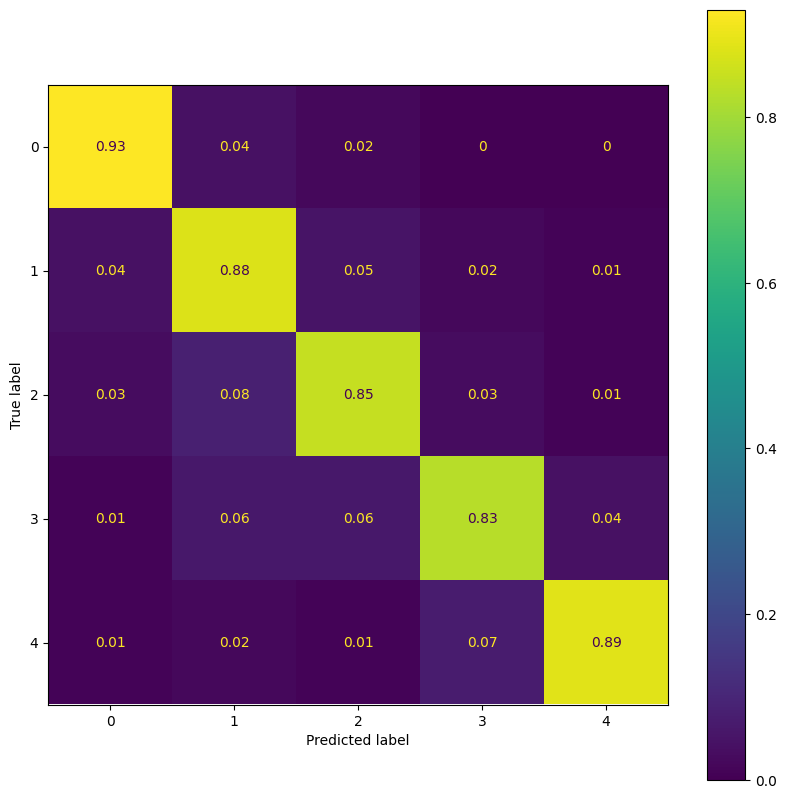

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

np.set_printoptions(precision=2)
cm_meta = confusion_matrix(act_y, pred_y, normalize='true')
cmp = ConfusionMatrixDisplay(cm_meta, display_labels=range(5))
for i, j in itertools.product(range(cm_meta.shape[0]), range(cm_meta.shape[1])):
        cm_meta[i,j] = format(cm_meta[i, j], '.2f')
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

In [27]:
# Get some statistics
from sklearn.metrics import classification_report
print(classification_report(act_y, pred_y))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1187
           1       0.88      0.88      0.88      2409
           2       0.91      0.85      0.88      2240
           3       0.65      0.83      0.73       429
           4       0.95      0.89      0.92      1195

    accuracy                           0.88      7460
   macro avg       0.85      0.88      0.86      7460
weighted avg       0.88      0.88      0.88      7460



In [28]:
# We now train the random forest on the whole dataset
rf_trained = rf_model.fit(metadata, metalabels)

In [30]:
# Save the model
save_model(rf_trained, models_path, "rf_trained_1")